### 목적
- 복잡한 애플리케이션을 여러 개의 전문 에이전트로 분할아여 문제 해결을 위해 함께 작동

#### 다중에이전트
- 하나의 에이전트에 너무 많은 도구를 가지고 있으면, 어떤 도구를 사용할지에 대한 잘못된 결정을 내린다.
- 맥락이나 기억이 너무 커져서 하나의 에이전트가 추적하기 어려움
- 전문성을 나누어 조율된 워크플로우 구성 (예시: 분석 전문가 , 요약 전문가 등)

#### 다중에이전트 패턴
- LangChain/LangGraph에서 다중에이전트를 설계할 때는 두 가지 접근 방법이 있다.

| 패턴                  | 작동 방식                                                                                                          | 제어 흐름(Control flow)                                  | 대표 사례                     |
| ------------------- | -------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------- | ------------------------- |
|  **Tool Calling** | “감독자(Supervisor)” 에이전트가 다른 에이전트들을 **도구(tools)**처럼 호출한다. <br> 하위 에이전트들은 사용자를 직접 상대하지 않고, 요청받은 작업만 수행해 결과를 반환한다. | **중앙집중형(Centralized)** — 모든 요청과 응답은 Supervisor를 거친다. | 워크플로우 오케스트레이션, 단계적 태스크 관리 |
|  **Handoffs**     | 현재 활성화된 에이전트가 “이건 다른 에이전트가 맡는 게 낫겠어” 하고 **제어권(Control)을 넘긴다.** <br> 사용자도 새 에이전트와 직접 대화하게 된다.                   | **분산형(Decentralized)** — 에이전트 간에 “주도권”이 바뀐다.         | 도메인별 전문 상담, 대화형 멀티-봇 협업   |



#### 구조적 분류
- LangChain에서 다중에이전트는 3가지 패턴으로 구현할 수 있다.

| 유형                                     | 설명                                              | 예시                                  |
| -------------------------------------- | ----------------------------------------------- | ----------------------------------- |
| **병렬형 (Parallel)**                     | 여러 에이전트가 동시에 작업을 수행한 뒤 결과를 병합                   | 예: 요약/번역/감성분석 동시 수행                 |
| **직렬형 (Sequential)**                   | 앞 에이전트의 결과를 다음 에이전트가 이어받아 처리                    | 예: 검색 → 요약 → 평가                     |
| **조정형 (Coordinator / Manager-Worker)** | 상위 조정자(Coordinator)가 하위 에이전트들을 호출하고, 각자의 결과를 취합 | 예: 프로젝트 매니저 Agent가 3명의 팀원 Agent를 지휘 |


#### Tool Calling
- 컨트롤러가 다른 에이전트들을 필요할 때 호출되는 도구로 취급한다.
    - 컨트롤러는 **오케스트레이션**을 관리 
    - **오케스트레이션**: 전체 흐름 설계, 각 에이전트 호출 순서, 조건, 데이터 전달, 종료 조건 등을 중앙에서 지휘자가 조율하는 구조
- 하위 에이전트들은 사용자와의 연결이 없다. -> 필요하다면 handoff 방식 사용
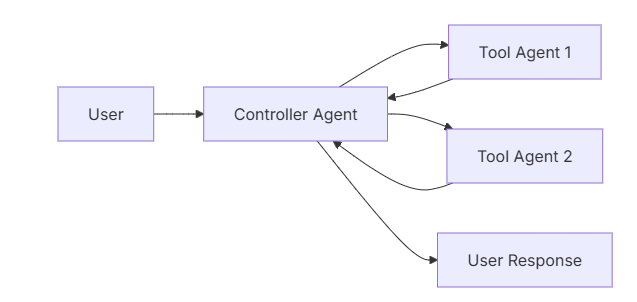

In [ ]:
# tool calling 패턴 -> 슈퍼바이저가 서브에이전트를 툴처럼 호출

import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.tools import tool, ToolRuntime

load_dotenv()

llm = ChatOpenAI(model='gpt-4o-mini', api_key=os.getenv('OPENAI_API_KEY'))

@tool
def add(a: int, b: int) -> int:
    """두 정수 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """두 정수 a와 b를 곱합니다."""
    return a * b

@tool
def divide(a: int, b: int) -> float:
    """a를 b로 나눕니다. 0으로는 나눌 수 없습니다."""
    if b == 0:
        raise ValueError("0으로는 나눌 수 없습니다.")
    return a / b

# 서브에이전트: 연산 전문가
calc_subagent = create_agent(model=llm, tools=[add, multiply, divide])

# 상위에이전트에서 호출할 서브에이전트 -> 툴 처럼 정의
@tool("calc_subagent")
def call_calc_agent(query: str):
    """description="연산 전문가 서브에이전트에게 계산을 위임합니다. 자연어 수식/계산 요청만 넘기세요."""
    result = calc_subagent.invoke({
        'messages': [{'role': 'user', 'content': query}]
    })
    return result['messages'][-1].content 
    # 서브에이전트가 툴로써 호출되었기 때문에 슈퍼바이저에게 ToolMessage객체로 들어간다.

agent = create_agent(model=llm, tools=[call_calc_agent])

result = agent.invoke({
    "messages": [{"role": "user", "content": "calc_exec로 (12 + 7) * 3 계산해줘"}]
})

print(result["messages"][-1].content)

계산 결과는 \(57\)입니다.


: 

#### 하위에이전트 입력 제어
- 슈퍼바이저가 하위에이전트에게 전달하는 입력을 제어하는 두 가지 주요 수단
    - 프롬프트 수정: 메인 에이전트의 프롬프트나 도구 메타데이터를 조정하여 서브에이전트를 호출하는 시기와 방법을 더 잘 안내한다.
    - 컨텍스트 주입: 에이전트의 상태에서 가져오도록 도구 호출을 조정하여 정적 프롬프트에 어려운 입력(전체 메시지 기록, 이전 결과 등)을 추가한다.

In [ ]:
from langchain.agents import AgentState
from langchain.tools import tool, ToolRuntime

class CustomState(AgentState):
    example_state_key: str

@tool("subagent1_name")
def call_subagent1():
    """subagent1_description"""
    